# **Contents**<a id='toc0_'></a>    
- [Training Notebook](#toc1_)    
- [Training models](#toc2_)    
- [Riemann data](#toc3_)    
  - [Train data generation](#toc3_1_)    
- [Model Training](#toc4_)    
- [Model Evaluation](#toc5_)    
  - [Comparison on Training set](#toc5_1_)    
  - [Compare with best model](#toc5_2_)    
- [Miscellaneous](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=5
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Training Notebook](#toc0_)
This notebook showcases the training and evaluation of a Speed Model in the trafsyn repository

In [23]:
import torch, gc, os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import trafsyn
from trafsyn.utils import *
from trafsyn.plot import *
from trafsyn.torchUtils import *
from trafsyn.torchModels import *
from trafsyn.Baselines.LWR import *
from trafsyn.Baselines.NumSchemes import *
%matplotlib inline

# Working directory
%cd ~/programmation/traffic-model-synthesis/

#load all datasets
data1 = loadData("1wave.npy")
data5 = loadData("5waves.npy")
dataLWR = loadData("LWRexact.npy")
dataHD = loadData("LaxHopfHD.npy")
dataTR = loadData("Triangular.npy")

/users/eleves-b/2020/victor.morand/programmation/traffic-model-synthesis


# <a id='toc2_'></a>[Training models](#toc0_)

# <a id='toc3_'></a>[Riemann data](#toc0_)

## <a id='toc3_1_'></a>[Train data generation](#toc0_)

Loading existing data
loaded 210 Riemann waves with shape (Nx,Nt)=(801, 400)
             	dx=0.01,
             	dt=0.01
1


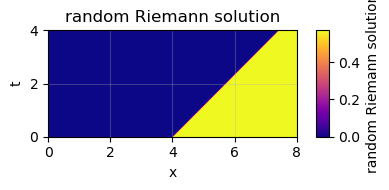

In [24]:
args = {
    #Greenshield variables
    "v" : 1,
    "rmax" : 4,
    #grid params of Training Set
    "dx" : .01,
    "dt" : .01,
    "N"  : 15,   #generate N(N-1) Riemann waves 
    "Nts": 400,   #number of ts
}

CFL = args['v'] * args['dt'] / args['dx']

#generate or load Training Set
TrainSet = GenerateGrRiemannTrainingSet(**args,plot=True,save=1)

#rapid evaluation of model on training set 
def EvaluateOnRiemann(model:Model):
    mses = []
    Nts = TrainSet[0].shape[1]
    for Rdata in TrainSet:
        mses.append(np.mean((model(Rdata[:,0],Nts-1) - Rdata[:,1:])**2))
    print("MSE on training Riemann Data : ",np.mean(mses))

def ReduceTS(RiemannData,Nts):
    """Assume CFL=1, and vmax = 1"""
    Reduced = []
    Nx = RiemannData[0].shape[0]
    border = max(int((Nx-2*Nts)/2) - 1 , 0)
    for data in RiemannData:
        Reduced.append(data[border:-(border+1),:Nts])
    return Reduced


# check random sample in data
i = np.random.randint(args['N'])
print(i)
PlotData(TrainSet[i],figsize=(4,2),title="random Riemann solution")
plt.show()

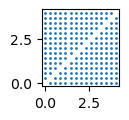

In [7]:
filtered = []
x=[]
y=[]
for data in TrainSet:
    x.append(data[0,0])
    y.append(data[-1,0])
    if data[0,0] > data[-1,0]:
        filtered.append(data)
plt.figure(figsize=(1,1))
plt.scatter(x,y,s=1)
plt.show()
#RiemannDataQs = filtered

# <a id='toc4_'></a>[Model Training](#toc0_)

In [35]:
%cd Training\ Scripts

[Errno 2] No such file or directory: 'Training Scripts'
/users/eleves-b/2020/victor.morand/programmation/traffic-model-synthesis/Training Scripts


params: 1291


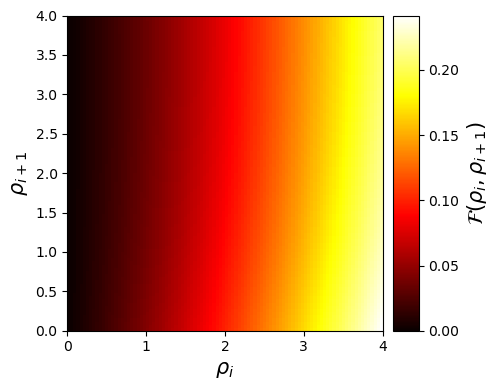

In [22]:
dtype= torch.float32
a = torch.rand((1,1,20),dtype=dtype)
init = None
#init = "INIT.pth"

torch.manual_seed(1)
if init: RModel = loadTorchModel(init,dtype=dtype)
else:
    # reinitialize model parameters if we get 0 in output of flow model
    RModel = cnnSpeedModel((1,2),
                                depth=6,
                                hidden=15,
                                dx = args['dx'],
                                dt = args['dt'],
                                activation=nn.ELU,
                              dtype=dtype)
    #init_cst(RModel)
    torch.save(RModel.state_dict(),"INIT.pth")
 
#define flow fx
flowfx = lambda x : torch.mul(x.to(dtype),RModel.speedModel.cpu()(x.to(dtype)))
# flowfx = lambda x : RModel.flowModel.cpu()(x.to(dtype))
print(f"params: {RModel.count_parameters()}")
DrawFingerPrint([GetFingerPrint(flowfx,rmax=4)],rmax=4,cmap='hot')

using GPU : NVIDIA GeForce RTX 3090
Train model with TBPTT: Nts 200 | loss mse | b_size 210 | k1 50 | decay 0.99 
Epoch[1/500], Step [1/1], mse Loss: 17.706785,LR: 1.000e-04
Epoch[52/500], Step [1/1], mse Loss: 15.021608,LR: 1.000e-04
Epoch[103/500], Step [1/1], mse Loss: 4.623572,LR: 1.000e-04
Epoch[154/500], Step [1/1], mse Loss: 0.406268,LR: 1.000e-04
Epoch[205/500], Step [1/1], mse Loss: 0.362658,LR: 1.000e-04
Epoch[256/500], Step [1/1], mse Loss: 0.367615,LR: 1.000e-04
Epoch[307/500], Step [1/1], mse Loss: 0.342735,LR: 1.000e-04
Epoch[358/500], Step [1/1], mse Loss: 0.276157,LR: 1.000e-04
Epoch[409/500], Step [1/1], mse Loss: 0.308986,LR: 1.000e-04
Epoch[460/500], Step [1/1], mse Loss: 0.285689,LR: 1.000e-04
Performed 500 epochs in 9.7e+02s: 0.518 epochs/s


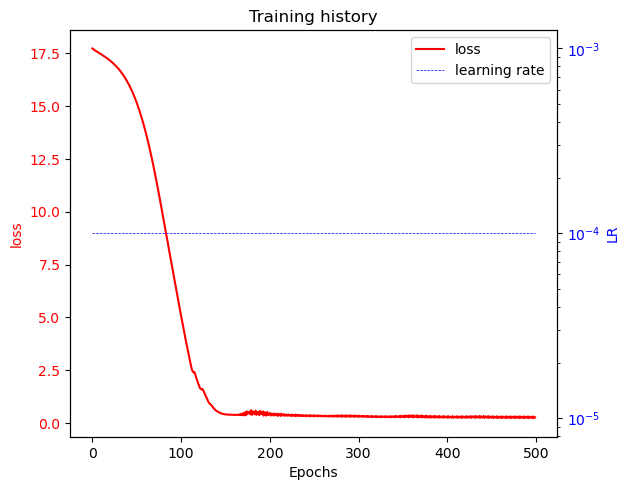

In [17]:
h=[]
RModel.double()
for nts in [200]:
    h += TBPTT(RModel,
                ReduceTS(TrainSet,nts),
                k1 = 50,
                epochs=500,
                patience=50,
                decay=.99,
                learning_rate=1e-4,
                optimizer = torch.optim.Adam,
        )
PlotHistory(h)
torch.save(RModel.state_dict(),"Scheckpoint1.pth")

using GPU : NVIDIA GeForce RTX 3090
Train model with TBPTT: Nts 400 | loss mse | b_size 210 | k1 100 | decay 1.0 
Epoch[1/1], Step [1/1], mse Loss: 0.038860,LR: 0.000e+00
Stopping ...
Performed 1 epochs in 0.71s: 1.41 epochs/s
using GPU : NVIDIA GeForce RTX 3090
Train model with TBPTT: Nts 300 | loss mse | b_size 210 | k1 100 | decay 0.99 
Epoch[1/10000], Step [1/1], mse Loss: 0.012368,LR: 1.000e-05
Epoch 00218: reducing learning rate of group 0 to 5.0000e-06.
Epoch 00821: reducing learning rate of group 0 to 2.5000e-06.
Epoch[1002/10000], Step [1/1], mse Loss: 0.011667,LR: 2.500e-06
Epoch 01752: reducing learning rate of group 0 to 1.2500e-06.
Epoch[2003/10000], Step [1/1], mse Loss: 0.011505,LR: 1.250e-06
Epoch[3004/10000], Step [1/1], mse Loss: 0.011403,LR: 1.250e-06
Epoch[4005/10000], Step [1/1], mse Loss: 0.011228,LR: 1.250e-06
Epoch[5006/10000], Step [1/1], mse Loss: 0.011099,LR: 1.250e-06
Epoch[6007/10000], Step [1/1], mse Loss: 0.010917,LR: 1.250e-06
Epoch[7008/10000], Step [1/

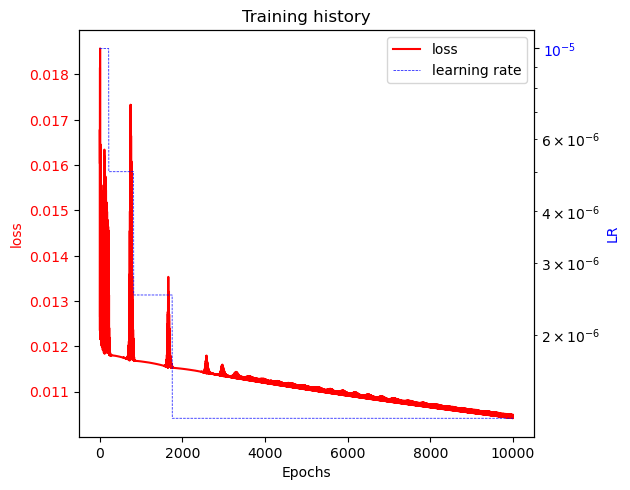

In [26]:
h=[]
for nts in [300]:
    h += TBPTT(RModel,
                ReduceTS(Filtered,nts),
                timesteps = nts,
                k1 = 100,
                epochs=10000,
                patience=100,
                decay=0.99,
                learning_rate=1e-5,
                optimizer = torch.optim.Adam,
        )
torch.save(RModel.state_dict(),"Scheckpoint2.pth")
_=TBPTT(RModel, TrainSet,epochs=1,learning_rate=0)
PlotHistory(h)

In [ ]:
# We can save the model as follows
torch.save(RModel.state_dict(),"Scheckpoint.pth")

# <a id='toc5_'></a>[Model Evaluation](#toc0_)

In [37]:
ts = 400
_=TBPTT(RModel, ReduceTS(TrainSet,ts),timesteps=ts,epochs=1,learning_rate=0,k1=100)
_=TBPTT(BestModel, ReduceTS(TrainSet,ts),timesteps=ts,epochs=1,learning_rate=0,k1=100)

using GPU : NVIDIA GeForce RTX 3090
Train model with TBPTT: Nts 400 | loss mse | b_size 210 | k1 100 | decay 1.0 
Epoch[1/1], Step [1/1], mse Loss: 0.014058,LR: 0.000e+00
Stopping ...
Performed 1 epochs in 0.82s: 1.22 epochs/s
using GPU : NVIDIA GeForce RTX 3090
Train model with TBPTT: Nts 400 | loss mse | b_size 210 | k1 100 | decay 1.0 
Epoch[1/1], Step [1/1], mse Loss: 0.019688,LR: 0.000e+00
Stopping ...
Performed 1 epochs in 3.5s: 0.282 epochs/s


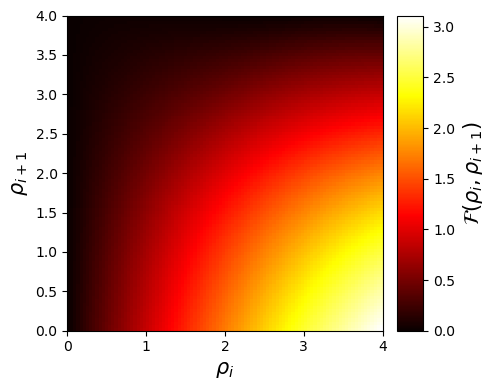

In [18]:
#extract numerical flux function from speedModel and draw its fingerprint
dtype = next(RModel.parameters()).dtype
flowfx = lambda x : torch.mul(x.to(dtype),RModel.speedModel.cpu()(x.to(dtype)))

DrawFingerPrint([GetFingerPrint(flowfx,4)],4,cmap='hot')

## <a id='toc5_1_'></a>[Comparison on Training set](#toc0_)

Godunov Baseline:
MODEL EVALUATION...
number of parameters: 2
Mean Square Error of model on data:  0.0013417865434405553
Speed Model:
MSE on training Riemann Data :  0.002130360663861692
MODEL EVALUATION...
number of parameters: 591
Mean Square Error of model on data:  0.009906844393484323


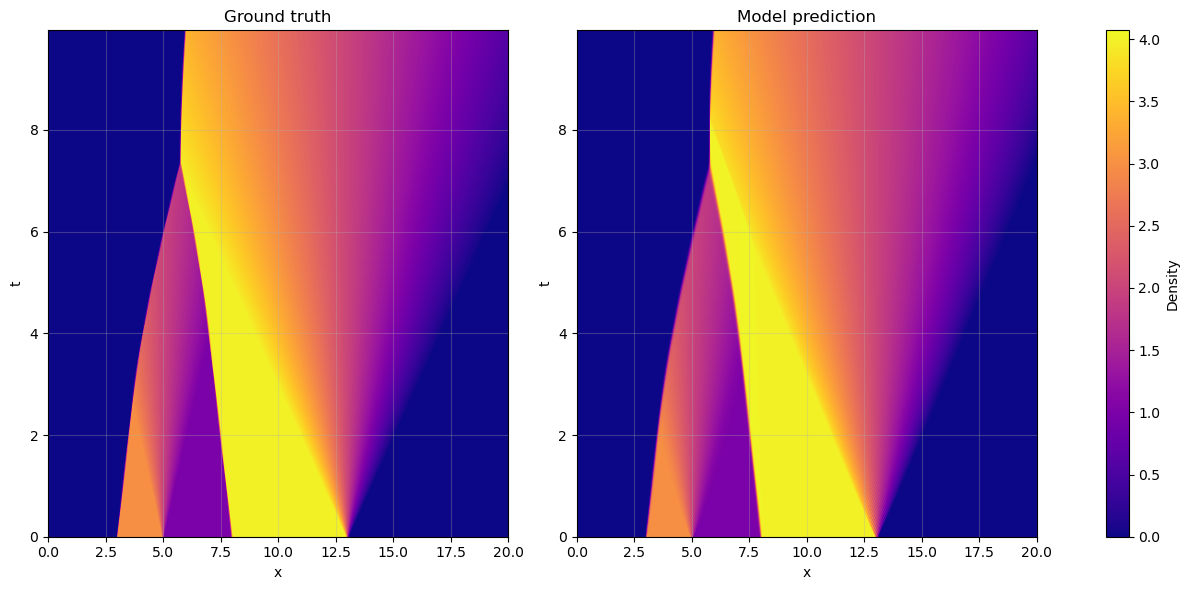

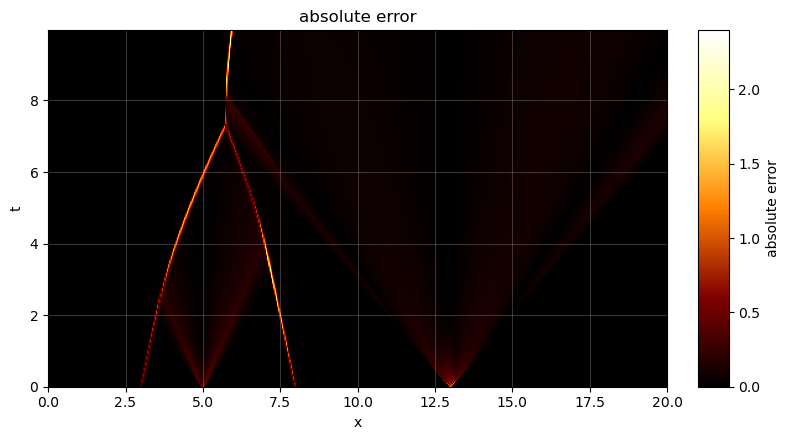

In [19]:
#load baseline Gmodel and data
data = dataHD
Gmodel = GodunovModel(f=f_greenshield,q_c=2)


print("Godunov Baseline:")
# EvaluateOnRiemann(Gmodel)
evaluate(Gmodel,data,plot=False,hardBC=True)

print("Speed Model:")
EvaluateOnRiemann(RModel)
evaluate(RModel,data,animate=0,hardBC=True)

## <a id='toc5_2_'></a>[Compare with best model](#toc0_)

MSE on training Riemann Data :  4.928141830100864e-05
MODEL EVALUATION...
number of parameters: 1021
Mean Square Error of model on data:  0.0004980608212071948


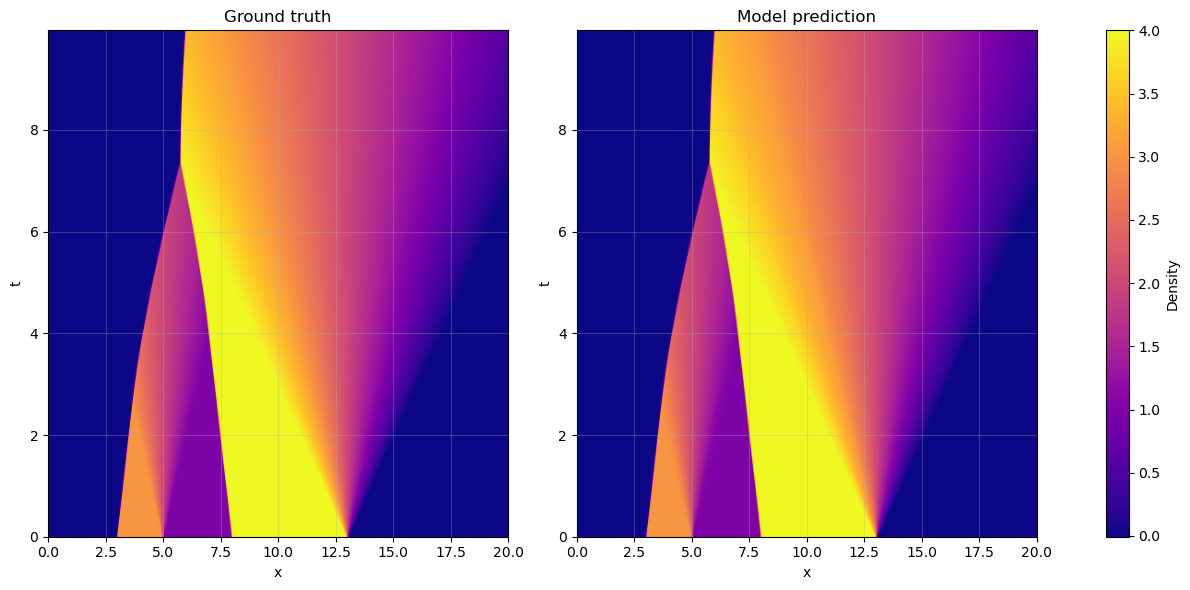

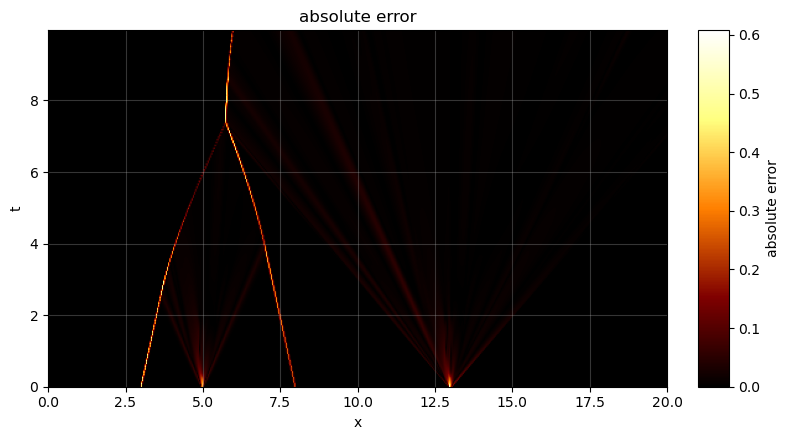

In [13]:
paramsPath = "../models/nnSpeedModel.pth"
# paramsPath = "Scheckpoint4.pth"

data = dataHD

BestModel = loadTorchModel(paramsPath)
EvaluateOnRiemann(BestModel)
evaluate(BestModel, data )

# <a id='toc6_'></a>[Miscellaneous](#toc0_)

In [ ]:
def DrawFD(flowfx,Normalize=True):
    densities_np = np.linspace(0,2,500)
    #make them as a batch for flow model
    densities_torch = torch.tensor(densities_np).unsqueeze(1).unsqueeze(1)
    if Normalize:
        #compute 
        C = flowfx(densities_torch[0:1,:,:]).detach().numpy().item()
    else :
        C = 0
    flows = flowfx(densities_torch)
    flows_np = flows.detach().squeeze(1).squeeze(1).numpy() - C
    #Real speed function
    GTflow = np.maximum(f_tr(densities_np),0)
    plt.figure(figsize=(6,5))
    plt.plot(densities_np,GTflow , "c-",label="Greenshield flux", linewidth = 3)
    plt.plot(densities_np,flows_np, 'r--',label="Flow Model flux", linewidth = 3 )
    plt.xlabel("Density")
    plt.ylabel("Flow")
    plt.legend()
    return

# print(flowfx)
DrawFD(flowfx)